<a href="https://colab.research.google.com/github/NguyenLoi851/RecognizeHandwrittenDigits/blob/master/Lenet5_Pytorch_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step**
- Import libraries
- Define constant and device
- Load data and preprocessing
- Visual data
- Build neural network
- Define model, loss function, optimize function
- Train model
- Test model
- Plot result
- Visual result

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision import models
from torchsummary import summary
from torch.nn.modules import padding

In [2]:
# Define constant and device
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10
train_split = 0.75
val_split = 1 - train_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# load dataset
train_dataset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Calculate mean and std of train and test dataset
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

train_mean, train_std = get_mean_and_std(train_dataloader)
train_mean, train_std = train_mean.item(), train_std.item()
print('Mean and std of train dataset: {:.4f}, {:.4f}'.format(train_mean, train_std))

test_mean, test_std = get_mean_and_std(test_dataloader)
test_mean, test_std = test_mean.item(), test_std.item()
print('Mean and std of test dataset: {:.4f}, {:.4f}'.format(test_mean, test_std))

Mean and std of train dataset: 0.1307, 0.3081
Mean and std of test dataset: 0.1327, 0.3107


In [5]:
# Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data', train = True, 
                transform = transforms.Compose([transforms.Resize((32,32)), 
                transforms.ToTensor(), 
                transforms.Normalize(mean = (train_mean,), std = (train_std,))]), 
                download = True)

# Split to train and validation dataset

num_train_samples = int(len(train_dataset)*train_split)

num_val_samples = int(len(train_dataset)*val_split)

(train_dataset, val_dataset) = torch.utils.data.random_split(train_dataset,
                                [num_train_samples, num_val_samples], 
                                generator = torch.manual_seed(10))


train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = torchvision.datasets.MNIST(root = './data', train = False, 
                transform = transforms.Compose([transforms.Resize((32,32)), 
                transforms.ToTensor(),
                transforms.Normalize(mean = (test_mean,), std = (test_std,))]), 
                download = True)

test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size)

val_dataloader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = batch_size)

In [6]:
# Visual data shape
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
print('Batch:',batch_idx)
print('Shape of input data:', example_data.shape)
print('Shape of output target:', example_targets.shape)

Batch: 0
Shape of input data: torch.Size([64, 1, 32, 32])
Shape of output target: torch.Size([64])


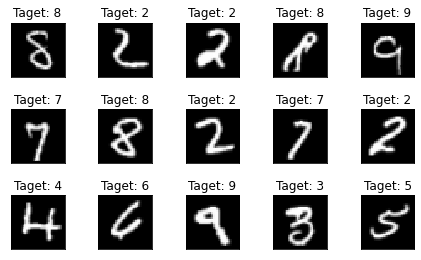

In [7]:
# Visual data
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Taget: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


In [8]:
# Build neural network
class Net(nn.Module):
  def __init__(self,num_classes):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
    self.tanh1 = nn.Tanh()
    self.avgpool1 = nn.AvgPool2d(kernel_size=(2,2), stride = 2)

    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
    self.tanh2 = nn.Tanh()
    self.avgpool2 = nn.AvgPool2d(kernel_size=(2,2), stride=2)
    
    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.tanh3 = nn.Tanh()
    self.fc3 = nn.Linear(in_features=84, out_features=num_classes)
    self.logSoftmax = nn.LogSoftmax(dim=1)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.tanh1(x)
    x = self.avgpool1(x)
    x = self.conv2(x)
    x = self.tanh2(x)
    x = self.avgpool2(x)
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.tanh3(x)
    x = self.fc3(x)
    x = self.logSoftmax(x)
    return x

In [9]:
# Summary parameter of model
model = Net(num_classes).to(device)
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
              Tanh-9                   [-1, 84]               0
           Linear-10                   [-1, 10]             850
       LogSoftmax-11                   [-1, 10]               0
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [10]:
# Define model, loss function, optimizer function
model = Net(num_classes).to(device)
cost_function = nn.CrossEntropyLoss()
optimizer_function = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Define list to save information about loss value and accuracy value
train_loss = []
train_acc = []

val_loss = []
val_acc = []

test_loss = []
test_acc = []

In [12]:
# Train model
total_step = len(train_dataloader)
for epoch in range(num_epochs):
  model.train()

  totalTrainLoss = 0
  totalValLoss = 0
  trainCorrect = 0
  valCorrect = 0

  for batch_idx, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = cost_function(outputs, labels)
    optimizer_function.zero_grad()
    loss.backward()
    optimizer_function.step()

    totalTrainLoss += loss
    trainCorrect += (outputs.argmax(1) == labels).sum().item()

  with torch.no_grad():
    model.eval()

    for batch_idx, (images, labels) in enumerate(val_dataloader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      totalValLoss += cost_function(outputs, labels)
      valCorrect += (outputs.argmax(1) == labels).sum().item()

  avgTrainLoss = totalTrainLoss / len(train_dataloader.dataset)
  avgValLoss = totalValLoss / len(val_dataloader.dataset)
  trainCorrect /= len(train_dataloader.dataset)
  valCorrect /= len(val_dataloader.dataset)

  train_loss.append(avgTrainLoss.cpu().detach().numpy())
  train_acc.append(trainCorrect)
  val_loss.append(avgValLoss.cpu().detach().numpy())
  val_acc.append(valCorrect)

  print('Epoch: {}/{}'.format(epoch+1, num_epochs))
  print('Train loss: {:.4f}, Train accuracy: {:.4f}'.format(avgTrainLoss, trainCorrect))
  print('Val loss: {:.4f}, Val accuracy: {:.4f}\n'.format(avgValLoss, valCorrect))

with torch.no_grad():
  model.eval()
  outputsList = []
  for (images, labels) in test_dataloader:
    images = images.to(device)
    outputs = model(images)
    outputsList.extend(outputs.argmax(axis=1).cpu().numpy())
print(classification_report(test_dataset.targets.cpu().numpy(),
                            np.array(outputsList), target_names = test_dataset.classes))

Epoch: 1/10
Train loss: 0.0048, Train accuracy: 0.9121
Val loss: 0.0021, Val accuracy: 0.9601

Epoch: 2/10
Train loss: 0.0015, Train accuracy: 0.9702
Val loss: 0.0014, Val accuracy: 0.9717

Epoch: 3/10
Train loss: 0.0010, Train accuracy: 0.9799
Val loss: 0.0012, Val accuracy: 0.9764

Epoch: 4/10
Train loss: 0.0009, Train accuracy: 0.9823
Val loss: 0.0009, Val accuracy: 0.9816

Epoch: 5/10
Train loss: 0.0007, Train accuracy: 0.9858
Val loss: 0.0008, Val accuracy: 0.9845

Epoch: 6/10
Train loss: 0.0007, Train accuracy: 0.9867
Val loss: 0.0010, Val accuracy: 0.9800

Epoch: 7/10
Train loss: 0.0006, Train accuracy: 0.9882
Val loss: 0.0008, Val accuracy: 0.9837

Epoch: 8/10
Train loss: 0.0006, Train accuracy: 0.9884
Val loss: 0.0008, Val accuracy: 0.9853

Epoch: 9/10
Train loss: 0.0005, Train accuracy: 0.9905
Val loss: 0.0008, Val accuracy: 0.9851

Epoch: 10/10
Train loss: 0.0005, Train accuracy: 0.9887
Val loss: 0.0008, Val accuracy: 0.9842

              precision    recall  f1-score   sup

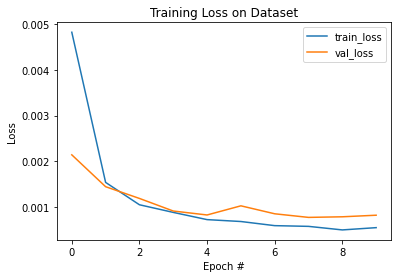

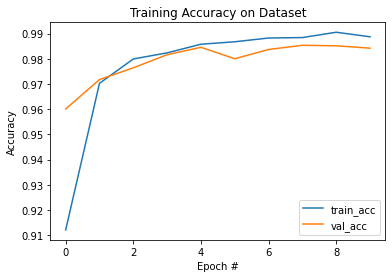

In [13]:
# Plot loss and accuracy
plt.figure()
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc = "upper right")

plt.figure()
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

In [14]:
# Test
with torch.no_grad():
  correct = 0
  total = 0
  y_test = []
  y_pred = []
  for images, labels in test_dataloader:
    images = images.to(device)
    labels = labels.to(device)
    y_test.extend(labels.cpu().numpy())
    outputs = model(images)
    y_pred.extend(outputs.argmax(axis=1).cpu().numpy())
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print('Accuracy of the network on the {} test images: {} %'.
        format(total, 100*correct/total))

Accuracy of the network on the 10000 test images: 98.63 %


Text(51.0, 0.5, 'True classes')

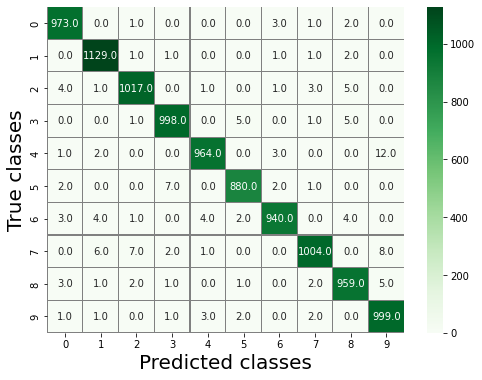

In [15]:
# Confusion matrix
con_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (8,6))
sns.heatmap(con_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)

In [16]:
# Visual test data shape
examples = enumerate(test_dataloader)
for _ in range(np.random.randint(0, high=len(test_dataloader))):
  batch_idx, (example_data, example_targets) = next(examples)
print('Batch:',batch_idx)
print('Shape of input data:', example_data.shape)
print('Shape of output target:', example_targets.shape)

Batch: 119
Shape of input data: torch.Size([64, 1, 32, 32])
Shape of output target: torch.Size([64])


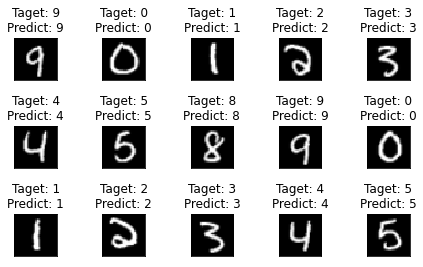

In [17]:
# Visual test data
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Taget: {}\nPredict: {}".format(example_targets[i], y_pred[batch_idx*batch_size+i]))
  plt.xticks([])
  plt.yticks([])